# TASK 3: BERT

This task involves the implementation of the BERT model for the news multi-class classification task.

In [1]:
! pip install imblearn
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import SMOTE
from collections import Counter

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.5 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import os
file_path = r"data_clean.csv"

if os.path.exists(file_path):
    print("File exists")
else:
    print("File does not exist")

File exists


In [ ]:
df = pd.read_csv(file_path)

# Display basic information about the dataset
print(df.info())

# Display the first few rows
print(df.head())

# Check class distribution
print(df['target'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871909 entries, 0 to 871908
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        871909 non-null  object
 1   target      871909 non-null  object
 2   Word Count  871909 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 20.0+ MB
None
                                                text              target  \
0   python courses python courses, python exercis...  academic interests   
1  the learning point open digital education. a r...  academic interests   
2   equl offers enzyme assay kits, reagent mixtur...  academic interests   
3  tech news, latest technology, mobiles, laptops...  academic interests   
4  the best it certification materials in usa | k...  academic interests   

   Word Count  
0         125  
1         147  
2         353  
3         143  
4         364  
target
academic interests                           73134
books and literatu

In [ ]:
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub('<[^>]*>', '', text)
    # Remove special characters and digits
    text = re.sub('[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply preprocessing to the 'text' column
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Display a sample of cleaned text
print(df['cleaned_text'].head())

0     python courses python courses python exercise...
1    the learning point open digital education a re...
2     equl offers enzyme assay kits reagent mixture...
3    tech news latest technology mobiles laptops  n...
4    the best it certification materials in usa  ki...
Name: cleaned_text, dtype: object


## Feature Extraction

In [ ]:
X = df['cleaned_text']
y = df['target']

## TRAINING-TESTING



In [ ]:
# Split off the test set (20% of the data)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the remaining 80% into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.4375, random_state=42, stratify=y_temp)

# Verify the split sizes
print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]:.2%})")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]:.2%})")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X.shape[0]:.2%})")

Training set size: 392358 (45.00%)
Validation set size: 305169 (35.00%)
Test set size: 174382 (20.00%)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pickle

# Save data
# with open('/content/drive/MyDrive/preprocessed_data.pkl', 'wb') as f:
#     pickle.dump((X_train, y_train, X_val, y_val, X_test, y_test), f)

# Load data
with open('/content/drive/MyDrive/preprocessed_data.pkl', 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pickle.load(f)

Mounted at /content/drive


## BERT MODEL



In [3]:
!pip install transformers==4.33.2
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.8 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3


In [4]:
import tensorflow as tf
import numpy as np
print(tf.__version__)
print(np.__version__)

# Setup TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()  # Detect TPUs
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

2.15.0
1.26.4


In [5]:
from sklearn.preprocessing import LabelEncoder

# Fit a LabelEncoder on the combined dataset
label_encoder = LabelEncoder()
all_labels = pd.concat([y_train, y_val, y_test])
label_encoder.fit(all_labels)

# Transform the labels
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

# Verify the mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'academic interests': 0, 'arts and culture': 1, 'automotives': 2, 'books and literature': 3, 'business and finance': 4, 'careers': 5, 'family and relationships': 6, 'food and drinks': 7, 'health': 8, 'healthy living': 9, 'hobbies and interests': 10, 'home and garden': 11, 'movies': 12, 'music and audio': 13, 'news and politics': 14, 'personal finance': 15, 'pets': 16, 'pharmaceuticals, conditions, and symptoms': 17, 'real estate': 18, 'shopping': 19, 'sports': 20, 'style and fashion': 21, 'technology and computing': 22, 'television': 23, 'travel': 24, 'video gaming': 25}


In [ ]:
import tensorflow
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(texts, labels, batch_size=128):
    """
    Tokenizes text and converts it to a tf.data.Dataset.
    """
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=128, return_tensors="tf")
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)  # Convert labels to tensor
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    return dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

train_dataset = tokenize_data(X_train, y_train)
val_dataset = tokenize_data(X_val, y_val)
test_dataset = tokenize_data(X_test, y_test)

In [ ]:
# Directory to save the datasets
save_dir = "/content/drive/My Drive/tokenized_datasets"

# Save tokenized datasets
tf.data.experimental.save(train_dataset, f"{save_dir}/train_dataset")
tf.data.experimental.save(val_dataset, f"{save_dir}/val_dataset")
tf.data.experimental.save(test_dataset, f"{save_dir}/test_dataset")
#
tokenizer.save_pretrained("/content/drive/My Drive/tokenized_datasets/tokenizer")

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


('/content/drive/My Drive/tokenized_datasets/tokenizer/tokenizer_config.json',
 '/content/drive/My Drive/tokenized_datasets/tokenizer/special_tokens_map.json',
 '/content/drive/My Drive/tokenized_datasets/tokenizer/vocab.txt',
 '/content/drive/My Drive/tokenized_datasets/tokenizer/added_tokens.json')

In [6]:
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

save_dir = "/content/drive/My Drive/tokenized_datasets"

# Load tokenized datasets
train_dataset = tf.data.experimental.load(f"{save_dir}/train_dataset")
val_dataset = tf.data.experimental.load(f"{save_dir}/val_dataset")
test_dataset = tf.data.experimental.load(f"{save_dir}/test_dataset")

# Load the tokenizer
tokenizer_path = r"/content/drive/My Drive/tokenized_datasets/tokenizer"

tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [7]:
def preprocess_data(inputs, labels):
    return inputs, labels

# Apply preprocessing
train_dataset = train_dataset.map(preprocess_data)
val_dataset = val_dataset.map(preprocess_data)

# Ensure dataset is batched and has an appropriate output signature
train_dataset = train_dataset.map(preprocess_data).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_data).prefetch(tf.data.experimental.AUTOTUNE)

In [9]:
# Use strategy scope for TPU
with strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_mapping))

    # Add dropout to the model
    model.config.hidden_dropout_prob = 0.2
    model.config.attention_probs_dropout_prob = 0.2

    # Optimizer with weight decay
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-2)

    # Learning rate scheduler
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-4 * (0.1 ** (epoch // 3))  # Decay by 0.1 every 3 epochs
    )

    # Compile model
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True
    )

# Train model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    # callbacks=[early_stopping, lr_schedule],
    callbacks=[lr_schedule],
    verbose=1
)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
3066/3066 [==============================] - 694s 194ms/step - loss: 1.0528 - accuracy: 0.7082 - val_loss: 0.9263 - val_accuracy: 0.7385 - lr: 1.0000e-04
Epoch 2/10
3066/3066 [==============================] - 520s 169ms/step - loss: 0.8333 - accuracy: 0.7636 - val_loss: 0.9425 - val_accuracy: 0.7389 - lr: 1.0000e-04
Epoch 3/10
3066/3066 [==============================] - 521s 170ms/step - loss: 0.7033 - accuracy: 0.8000 - val_loss: 0.9876 - val_accuracy: 0.7366 - lr: 1.0000e-04
Epoch 4/10
3066/3066 [==============================] - 519s 169ms/step - loss: 0.4910 - accuracy: 0.8593 - val_loss: 0.9990 - val_accuracy: 0.7469 - lr: 1.0000e-05
Epoch 5/10
3066/3066 [==============================] - 520s 170ms/step - loss: 0.4109 - accuracy: 0.8827 - val_loss: 1.0411 - val_accuracy: 0.7452 - lr: 1.0000e-05
Epoch 6/10
3066/3066 [==============================] - 519s 169ms/step - loss: 0.3499 - accuracy: 0.9004 - val_loss: 1.1019 - val_accuracy: 0.7426 - lr: 1.0000e-05
Epoch 7/10

In [10]:
# Save model to Google Drive
model.save_pretrained('/content/drive/MyDrive/my_bert_model/v2')

In [11]:
# Evaluate on test data
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy:.2%}")

1363/1363 [==============================] - 62s 44ms/step - loss: 1.1336 - accuracy: 0.7422
Test Accuracy: 74.22%


In [12]:
# Get predictions for validation and test sets
val_preds = model.predict(val_dataset).logits
test_preds = model.predict(test_dataset).logits

# Convert logits to class predictions
y_val_pred = np.argmax(val_preds, axis=1)
y_test_pred = np.argmax(test_preds, axis=1)

# Classification report on validation and test sets
val_report = classification_report(y_val, y_val_pred, output_dict=True)
test_report = classification_report(y_test, y_test_pred, output_dict=True)

print("Validation Set Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


1363/1363 [==============================] - 63s 45ms/step
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.86      0.84     25597
           1       0.64      0.59      0.61     11533
           2       0.87      0.87      0.87     12252
           3       0.91      0.92      0.91     17690
           4       0.60      0.60      0.60     12267
           5       0.99      1.00      0.99     13337
           6       0.62      0.65      0.63     12666
           7       0.63      0.65      0.64     10252
           8       0.62      0.65      0.64      8300
           9       0.67      0.65      0.66     13539
          10       0.76      0.61      0.68     10480
          11       0.68      0.60      0.64     10068
          12       0.71      0.75      0.73      9529
          13       0.69      0.71      0.70      9026
          14       0.69      0.73      0.71     13211
          15       0.68      0.68     

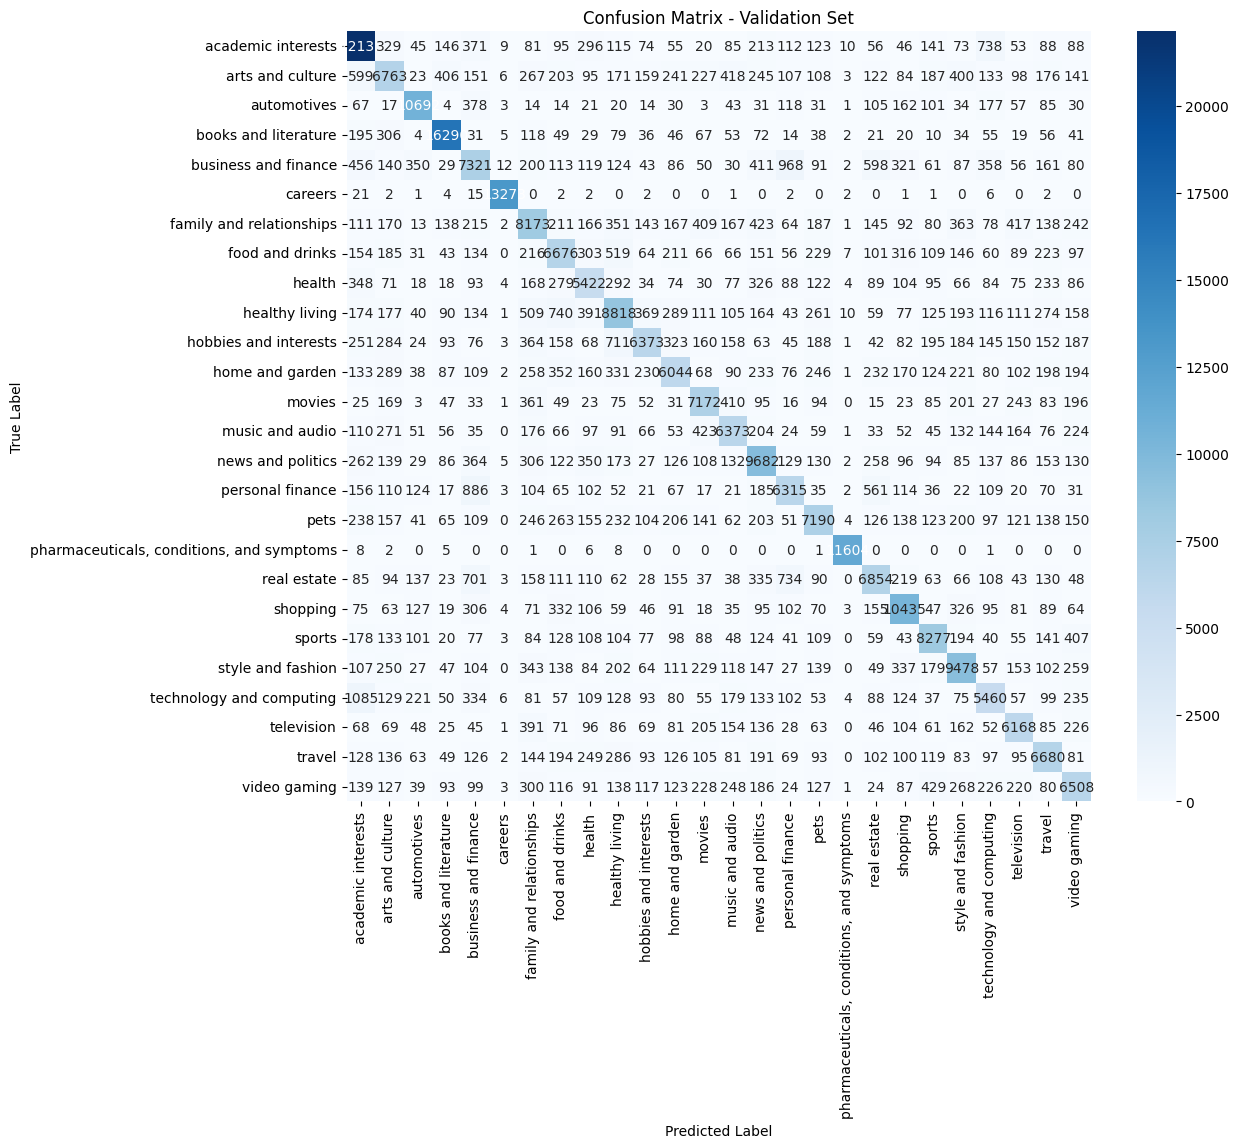

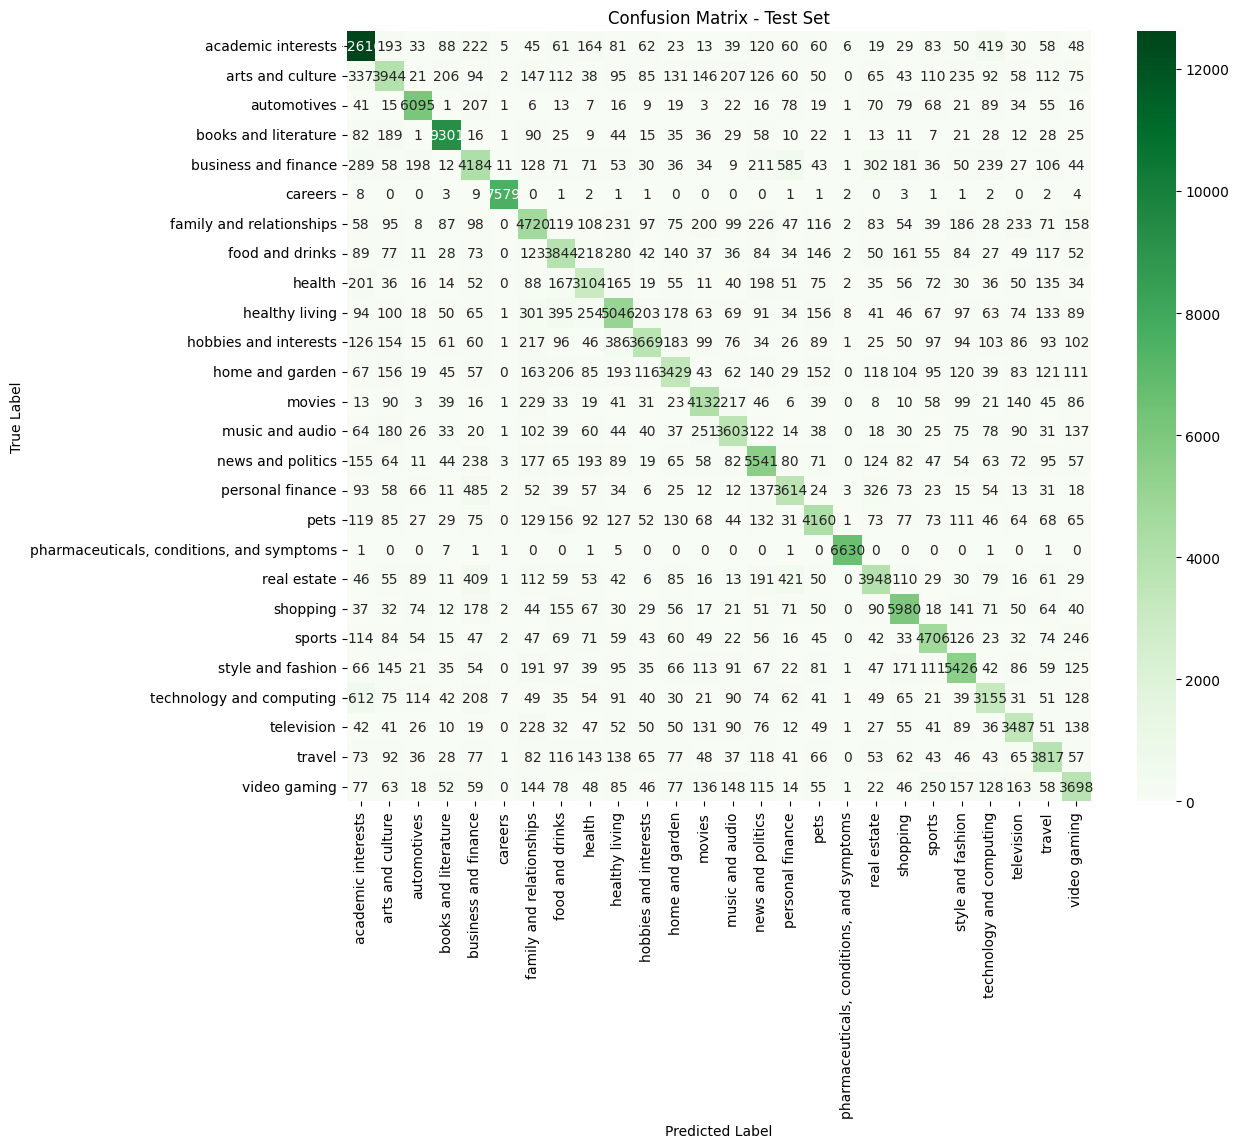

In [13]:
# Confusion matrix and heatmap for validation set
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(val_conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Validation Set")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Confusion matrix and heatmap for test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Test Set")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

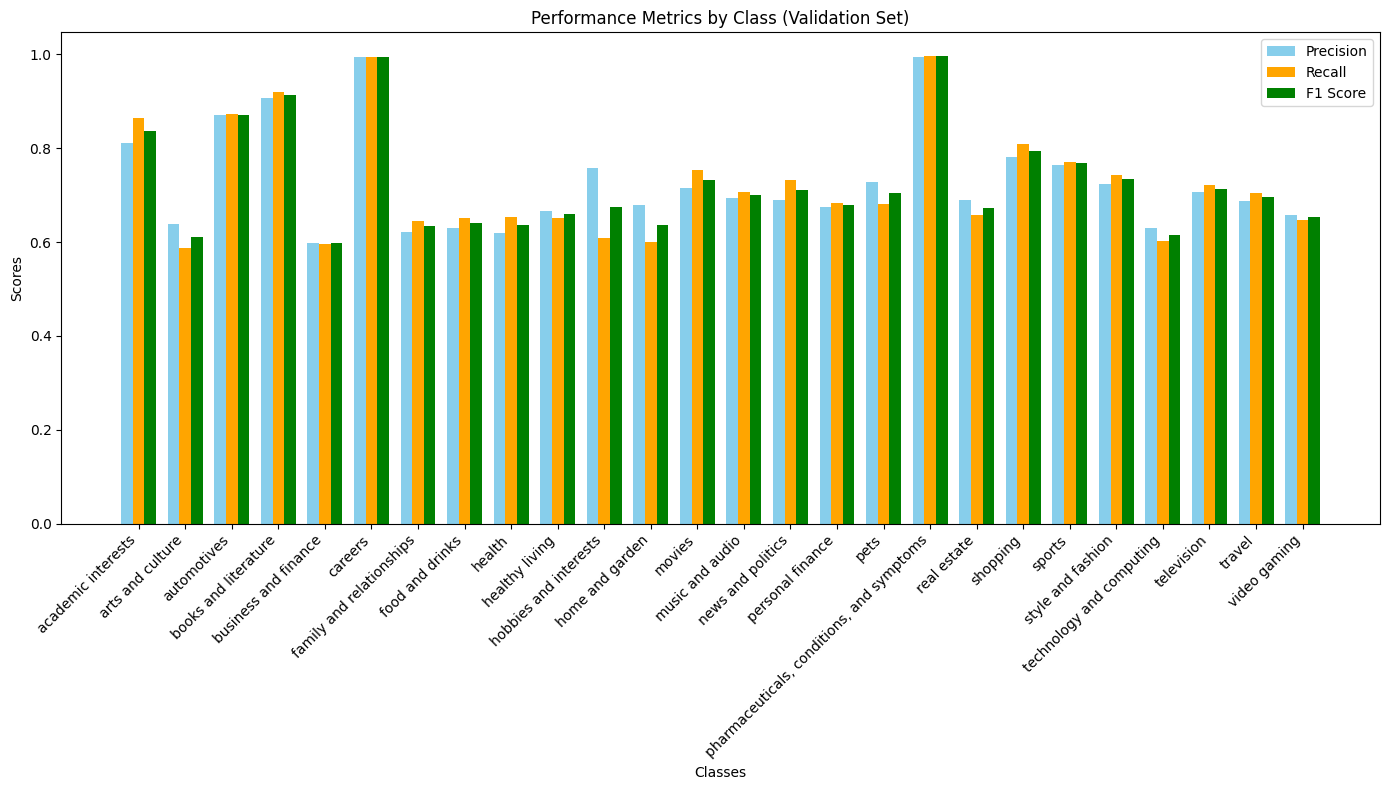

In [14]:
# Generate a classification report (validation set)
val_report = classification_report(y_val, y_val_pred, output_dict=True, target_names=label_encoder.classes_)

# Extract classes and metrics
classes = list(val_report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
precision = [val_report[cls]['precision'] for cls in classes]
recall = [val_report[cls]['recall'] for cls in classes]
f1_score = [val_report[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))  # The label locations
width = 0.25  # Width of the bars

# Bar plot for performance metrics
fig, ax = plt.subplots(figsize=(14, 8))
bars1 = ax.bar(x - width, precision, width, label='Precision', color='skyblue')
bars2 = ax.bar(x, recall, width, label='Recall', color='orange')
bars3 = ax.bar(x + width, f1_score, width, label='F1 Score', color='green')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Class (Validation Set)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')  # Rotate labels for better visibility
ax.legend()

plt.tight_layout()
plt.show()